c:\Users\iriku\Desktop\DLab\dev\backend\venv\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


{'loss': 4.877075515687466, 'location': -0.17528078, 'radian': 0.2540641}


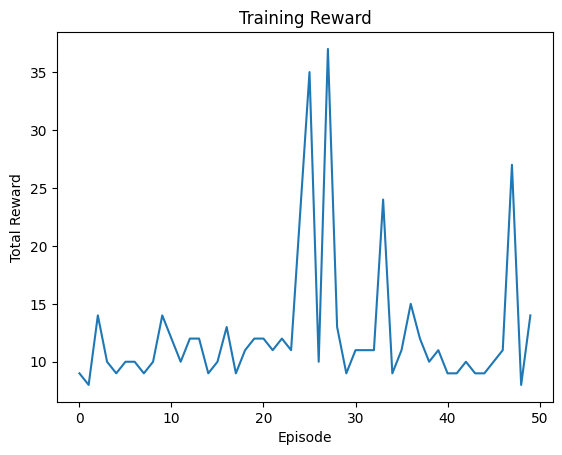

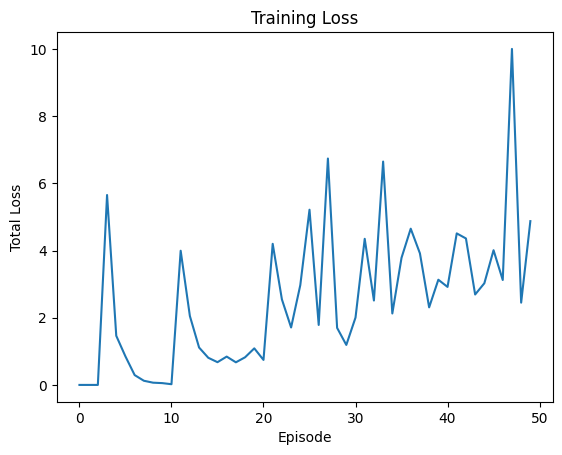

In [2]:
import os
import importlib
import gym
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch.optim as optim

# 活性化関数を取得する関数
def get_activation(activation_name):
    if activation_name == 'ReLU':
        return nn.ReLU()
    elif activation_name == 'Sigmoid':
        return nn.Sigmoid()
    elif activation_name == 'Tanh':
        return nn.Tanh()
    elif activation_name == 'Softmax':
        return nn.Softmax(dim=1)

# 最適化関数を取得する関数
def get_optimizer(optimizer_name, params, lr):
    if optimizer_name == 'SGD':
        return optim.SGD(params, lr)
    if optimizer_name == 'momentum':
        return optim.SGD(params, lr, momentum=0.8)
    if optimizer_name == 'Adam':
        return optim.Adam(params, lr)
    if optimizer_name == 'Adagrad':
        return optim.Adagrad(params, lr)
    if optimizer_name == 'RMSProp':
        return optim.RMSprop(params, lr)
    if optimizer_name == 'Adadelta':
        return optim.Adadelta(params, lr)

# 損失関数を取得する関数
def get_loss(loss_name):
    if loss_name == 'mse_loss':
        return nn.MSELoss()
    if loss_name == 'cross_entropy':
        return nn.CrossEntropyLoss()
    if loss_name == 'binary_corss_entropy':
        return nn.BCELoss()
    if loss_name == 'nll_loss':
        return nn.NLLLoss()
    if loss_name == 'hinge_embedding_loss':
        return nn.HingeEmbeddingLoss()

# リプレイバッファクラスの定義
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size
    
    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        self.buffer.append(data)
    
    def __len__(self):
        return len(self.buffer)
    
    def get_batch(self):
        data = random.sample(self.buffer, self.batch_size)
        state = np.stack([x[0] for x in data])
        action = np.array([x[1] for x in data])
        reward = np.array([x[2] for x in data])
        next_state = np.stack([x[3] for x in data])
        done = np.array([x[4] for x in data])
        return state, action, reward, next_state, done

# DQNエージェントクラスの定義
class DQNAgent:
    def __init__(self, train_info, QNet_model, device='cpu'):
        self.device = device
        self.gamma = 0.9  # 割引率
        self.lr = float(train_info['learning_rate'])
        self.epsilon = float(train_info['epsilon'])
        self.buffer_size = int(train_info['buffer'])
        self.batch_size = int(train_info['batch'])
        self.action_size = 2
        self.loss_func = get_loss(train_info['loss'])
        self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)
        self.qnet = QNet_model().to(device=self.device)
        self.qnet_target = QNet_model().to(device=self.device)
        self.optimizer = get_optimizer(train_info['optimizer'], self.qnet.parameters(), self.lr)
        self.optimizer.zero_grad()
    
    # ターゲットネットワークを同期する関数
    def sync_qnet(self):
        self.qnet_target.load_state_dict(self.qnet.state_dict())
    
    # 行動を選択する関数
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = torch.tensor(state[np.newaxis, :], dtype=torch.float32).to(device=self.device)
            qs = self.qnet.forward(state)
            return int(torch.argmax(qs))
    
    # Qネットワークを更新する関数
    def update(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
        if len(self.replay_buffer) < self.batch_size:
            return 0
        state, action, reward, next_state, done = self.replay_buffer.get_batch()
        state = torch.tensor(state, dtype=torch.float32).to(self.device)
        qs = self.qnet.forward(state)
        q = qs[torch.arange(self.batch_size), action]
        next_state = torch.tensor(next_state, dtype=torch.float32).to(self.device)
        next_qs = self.qnet_target.forward(next_state)
        next_q, index = next_qs.max(dim=1)
        reward = torch.tensor(reward, dtype=torch.float32).to(self.device)
        done = torch.tensor(done, dtype=torch.float32).to(self.device)
        target = reward + (1 - done) * self.gamma * next_q
        targets = self.qnet.forward(state)
        new_targets = [ts.clone().index_fill_(0, torch.tensor([i]), t) for ts, t, i in zip(targets, target, index)]
        targets = torch.stack(new_targets).to(self.device)
        loss = self.loss_func(q, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

# モデルを訓練する関数
def train_model(config):
    user_id = config["user_id"]
    project_name = config["Project_name"]
    model_id = config["model_id"]
    train_info = config["Train_info"]

    base_dir = "../user"
    model_path = os.path.join(base_dir, user_id, project_name, model_id, "model_config.py")
    spec = importlib.util.spec_from_file_location("Simple_NN", model_path)
    model_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(model_module)
    Simple_NN = model_module.Simple_NN

    env = gym.make('CartPole-v1')
    agent = DQNAgent(train_info, Simple_NN)

    epoch = train_info["epoch"]
    sync_interval = train_info["syns"]
    max_reward = 0
    rewards = []
    losses = []

    for episode in range(epoch):
        state, _ = env.reset()
        done = False
        total_reward = 0
        total_loss = 0
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            done = done or truncated
            loss = agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            total_loss += loss
        rewards.append(total_reward)
        losses.append(total_loss)

        if episode % sync_interval == 0:
            agent.sync_qnet()

        if max_reward < total_reward:
            max_reward = total_reward
            torch.save(agent.qnet.state_dict(), os.path.join(base_dir, user_id, project_name, model_id, "best_model.pth"))
        
        # print(f"Episode: {episode}, Loss: {total_loss:.4f}, Reward: {total_reward}")

    plt.figure()
    plt.plot(rewards)
    plt.title('Training Reward')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    photo_dir = os.path.join(base_dir, user_id, project_name, model_id, "photo")
    os.makedirs(photo_dir, exist_ok=True)
    plt.savefig(os.path.join(photo_dir, "training_reward.png"))

    plt.figure()
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Episode')
    plt.ylabel('Total Loss')
    plt.savefig(os.path.join(photo_dir, "training_loss.png"))

    env.close()
    return {"loss": total_loss, "location": state[0], "radian": state[2]}

# 訓練の設定を定義
config = {
    "user_id": "example_user_id",
    "Project_name": "CartPole",
    "model_id": "pole_model",
    "Train_info": {
        "loss": "mse_loss",
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "batch": 32,
        "epoch": 50,
        "buffer": 1000,
        "epsilon": 0.1,
        "syns": 10
    }
}

result = train_model(config)
print(result)
